## Notebook to illustrate how the probabilistic jerk finder works, using an example taken from NGK in 1969

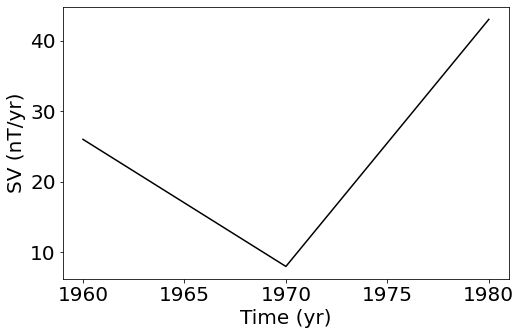

In [1]:
import matplotlib.pyplot as plt
import numpy as np
discretise_size = 400

time_for_plotting = np.linspace(1960,1980,discretise_size,endpoint=True)
fig, ax = plt.subplots( figsize=(8,5))
X0 = [1960,1970,1980]
Y0 = [26,    8,   43]

ax.plot(X0,Y0,'k');
ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('SV (nT/yr)',fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example1_NGK_raw_signal.pdf',bbox_inches='tight')

#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

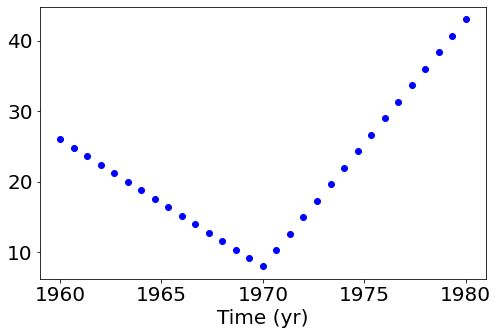

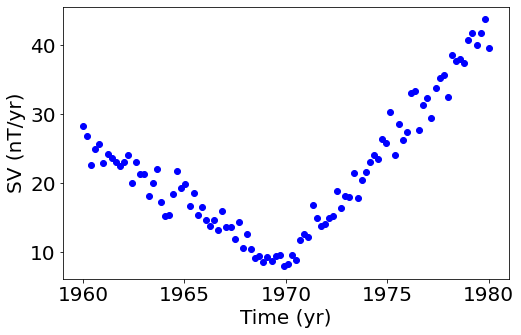

In [2]:
fig, ax = plt.subplots( figsize=(8,5))
np.random.seed(seed = 10)
NUM_DATA = 31
TIMES = np.linspace(1960,1980,NUM_DATA,dtype=float)
Y = np.interp(TIMES,X0, Y0) 
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time (yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('example1_NGK_sampled_signal.pdf',bbox_inches='tight')



fig, ax = plt.subplots( figsize=(8,5))
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(1960,1980,NUM_DATA,dtype=float)
delta_Y = 5/100 * (Y.max() - Y.min()) * np.ones(NUM_DATA)
Y = np.interp(TIMES,X0, Y0) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time (yr)',fontsize=20)
plt.ylabel('SV (nT/yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example1_NGK_noised_signal.pdf',bbox_inches='tight')

In [3]:
import os
import sys
sys.path.append( os.path.abspath('..') )
sys.path.append( os.path.abspath('.') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = Y.min()
Y_MAX = Y.max()

TIMES_MIN = 1960
TIMES_MAX = 1980
K_MIN = 0
K_MAX = 100
relative_sigmas = np.array([0.08, 0.02, 0.08])

sigmas = np.array([ (Y.max() - Y.min())*relative_sigmas[0],\
                (TIMES_MAX - TIMES_MIN)*relative_sigmas[1],\
                   (Y.max() - Y.min())*relative_sigmas[2]],dtype = float)

    
THIN = 100
NBINS = 1000
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)
# jerks:
jerk_data = np.zeros( (K_MAX *(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

#saved history for animations
jerk_history = np.zeros( ((NSAMPLE-burn_in)//THIN,2), dtype=int)
model_history = np.zeros( (discretise_size, (NSAMPLE-burn_in)//THIN),dtype=float)

(Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, 
MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data, \
model_history, jerk_history) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, 
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[16.39500046 33.61749649  5.27897882  5.29721737]


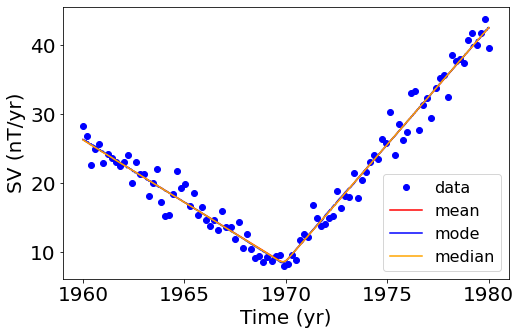

In [4]:
fig, ax = plt.subplots( figsize=(8,5))
ax.plot(TIMES,Y,'bo', label='data')
ax.plot(time_for_plotting,AV,'r', label='mean')
ax.plot(time_for_plotting,MODE, 'b',  label='mode')
ax.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
#ax.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
#ax.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
ax.legend(loc='lower right', fontsize=16)
ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('SV (nT/yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example1_NGK_posterior.pdf',bbox_inches='tight')

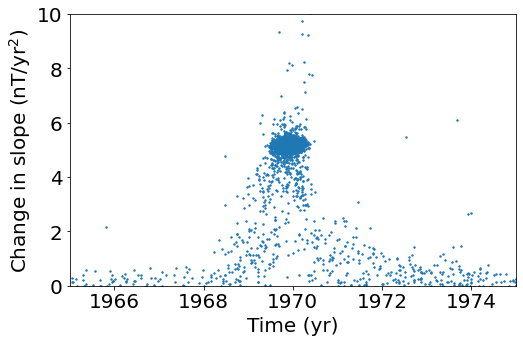

In [5]:
import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(8,5))
ax.scatter(jerk_data[0:size_jerk_data,0], jerk_data[0:size_jerk_data,1],s=2)
ax.set_xlim(1965,1975)
ax.set_ylim(0,10)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Change in slope (nT/yr$^2$)', fontsize=20)
plt.savefig('example1_NGK_scatter.pdf',bbox_inches='tight')

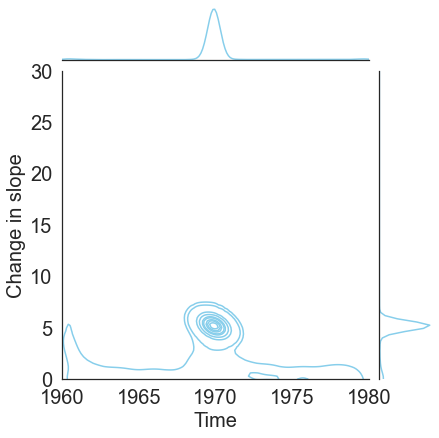

In [66]:
# Make kde image using seaborn:
import seaborn as sns
import pandas as pd
sns.set(style="white", color_codes=True)
joint_data = pd.DataFrame(data=jerk_data[0:size_jerk_data,:],columns=["time","change"])
joint_data = joint_data[(abs(joint_data["change"])<30) ]
image = sns.jointplot(x=joint_data.time, y=joint_data.change, kind = 'kde', ylim=[0,30],xlim = [1960,1980], color="skyblue")
plt.xlabel('Time', fontsize=20);
plt.ylabel('Change in slope', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example1_NGK_kde.pdf',bbox_inches='tight')

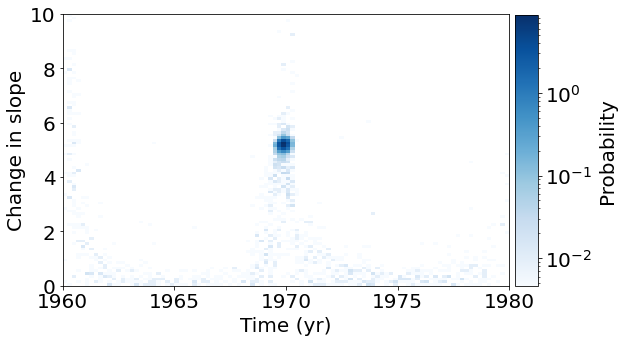

In [6]:
import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(8,5))
counts, xedges, yedges, im = ax.hist2d(jerk_data[0:size_jerk_data,0], jerk_data[0:size_jerk_data,1], bins=(100,100), range=[[1960,1980], [0,10]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb_ax = fig.add_axes([.91,.124,.04,.754])
cb = fig.colorbar(im,orientation='vertical',cax=cb_ax)
#cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)
plt.savefig('example1_NGK_2Dhist.pdf',bbox_inches='tight')

In [7]:
# Find maximum probability:
indices = np.unravel_index(np.argmax(counts),counts.shape)
print('Maximum occurs in time bin {0:3.3f} : {1:3.3f}'.format(xedges[indices[0]],xedges[indices[0]+1])  )
print('Maximum occurs in slope bin {0:3.3f} : {1:3.3f}'.format(yedges[indices[1]],yedges[indices[1]+1])  )


Maximum occurs in time bin 1969.800 : 1970.000
Maximum occurs in slope bin 5.200 : 5.300


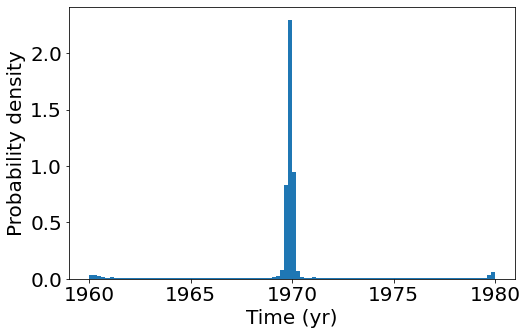

In [7]:
fig, ax = plt.subplots( figsize=(8,5))
marginal_counts, marginal_xedges, marginal_im = ax.hist( jerk_data[0:size_jerk_data,0], bins=100, range=[1960,1980],density=True)
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Probability density', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example1_NGK_changepoint_hist.pdf',bbox_inches='tight')

## Find the jerk uncertainty in time:

In [8]:
# Find jerks:

# 1. Find peaks in marginal histogram of changepoints satisfying criteria like min distance between jerks and jerk prominence, 
# 2. Find the subset of peaks for which the associated modal amplitude (from the 2d histogram) exceeds a certain threshold, label the peak a a jerk
# 3. Find the jerk width by seeing how far either side of the peak the 1d histogram drops to tau of the value at the peak.

# defaults:
# 
def find_jerks(data_timing, data_amplitude, number_time_bins, time_range, 
    number_amplitude_bins = 100, amplitude_range = [-50,50],
    jerk_min_amplitude = 1, min_distance = 4, \
    peak_prominence = 1, tau = 0.14):
    ''' 
    Function: find_jerks
    
    Returns a list of jerk attributes
    
        Parameters:
            data_timing (float, array): changepoint times
            data_amplitude: (float, array): changepoint slope changes
            number_time_bins (integer): number of bins in time
            time_range (list): start and end times
            
            Optional:
            jerk_min_amplitude (float): threshold for jerk identification
            min_distance (float): minimum distance between jerks
            prominence (float): prominence of jerks
            tau (float): threshold to characterise width of jerks
            
        Returns a list of jerk attributes in the form
            [jerk0, jerk1,...]
            where (for example) jerk0 is [jerk_time, jerk_amplitude, min_jerk_time, max_jerk_time]
            All four values are float; jerk_time is the most likely time for a jerk of amplitude jerk_amplitude, but it is uncertain with bounds given by min_jerk_time and max_jerk_time.
            
    Algorithm:
    1. Find peaks in marginal histogram of changepoints satisfying: min distance between jerks and jerk prominence. 
    2. Find the subset of peaks for which the associated slope change of maximum probability (from the 2d histogram) exceeds the threshold of jerk_min_amplitude.  See Scipy documentation for definition of prominence. 
    3. For these peaks ("jerks"), the jerk width is quantified by identifying the smallest time window that defines a drop in the 1d histogram of changepoint timing by tau on both sides. 
    If the changepoint histogram is Gaussian in shape, then 2 sigma corresponds to a drop in height of e^-2, or about 0.14. This defines then (roughly) a 95% credible interval.
    

    '''
    
    jerks_overall_info = []

    

    counts, xedges, yedges = np.histogram2d(data_timing, data_amplitude, bins=(number_time_bins,number_amplitude_bins), range=[time_range, amplitude_range])
    marginal_counts, marginal_xedges = np.histogram( data_timing, bins=number_time_bins, range=time_range)
    from scipy import signal

    peaks = signal.find_peaks(marginal_counts,distance=min_distance, prominence = peak_prominence * marginal_counts.mean() )  

    for peak_index in peaks[0]:
        jerk_info = np.zeros(4)
        index = counts[peak_index,:].argmax()  #find index corresponding to max probability
        jerk_amplitude = 0.5 * ( yedges[index] + yedges[index+1] )  #use the centre point of the bin
        if abs(jerk_amplitude) > jerk_min_amplitude:
            jerk_info[0] = 0.5 * ( marginal_xedges[peak_index] + marginal_xedges[peak_index+1] )  #use the centre point of the bin
            jerk_info[1] = jerk_amplitude

            min_jerk_time = marginal_xedges[0]
            max_jerk_time = marginal_xedges[-1]

            for i in range(peak_index,marginal_counts.shape[0]):  #count upwards in time to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    max_jerk_time = marginal_xedges[i]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the left edge of this bin.
                    break

            for i in range(peak_index,0,-1):  # count downwards to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    min_jerk_time = marginal_xedges[i+1]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the right edge of this bin.
                    break

            jerk_info[2], jerk_info[3] = min_jerk_time, max_jerk_time

            jerks_overall_info.append(jerk_info)
    return jerks_overall_info

    


In [9]:
data_timing = jerk_data[0:size_jerk_data,0]
data_amplitude = jerk_data[0:size_jerk_data,1]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
time_range = [TIMES_MIN,TIMES_MAX]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))

1 jerks found
Jerk 0 at time 1969.750000 with min/max of 1969.500000, 1970.500000


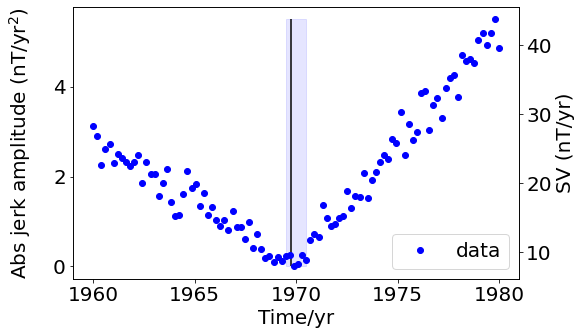

In [10]:
fig, ax = plt.subplots( figsize=(8,5))
axb = ax.twinx()

axb.plot(TIMES,Y,'bo', label='data')

axb.legend(loc='lower right',fontsize=20, labelspacing=0.2)
axb.tick_params(axis='both', which='major', labelsize=20)
axb.set_ylabel('SV (nT/yr)',fontsize=20)

#plot jerks
ymin = 0
ymax = max(abs(jerk[1]) for jerk in jerks_info)
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, ymax, colors='k')
    ax.fill_betweenx([ymin, ymax], jerk[2], jerk[3],alpha=0.1, color='blue')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('Abs jerk amplitude (nT/yr$^2$)', fontsize=20,labelpad=20)
ax.set_xlabel('Time/yr',fontsize=20)

plt.savefig('example1_NGK_posterior_with_jerks.pdf',bbox_inches='tight')




In [ ]:
# jerk spread is 1970.500000 - 1969.500000 = 1yr (for 2sigma). So 1 sigma = 0.25 yr.